In [1]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
vis = ['GRVI', 'NDVI', 'EVI', 'KTTC_GRN', 'RSR', 'NDII', 'NBR', 'KTTC_WET']
nvis = len(vis)
photosyn_vis = ['GRVI', 'NDVI', 'EVI', 'KTTC_GRN']
moisture_vis = ['NDII', 'NBR', 'KTTC_WET', 'RSR']
sites = ['CHITTY', 'KLOO', 'SILVER', 'SULPHUR']

In [3]:
fname = 'Masting_VI_Regressions_Table.csv'
masting_df = pd.read_csv(fname)
masting_df.drop(columns=['cone_count_stdv', 'mast_rel_year'], inplace=True)
for vi in vis:
    masting_df.drop(columns=['%s_intercept' % vi.lower()], inplace=True)

In [4]:
masting_df['site_idx'] = [sites.index(site_name) for site_name in masting_df['site_name']]
for vi in vis:
    mean = masting_df['%s_slope' % vi.lower()].mean()
    stdv = masting_df['%s_slope' % vi.lower()].std()
    masting_df['%s_slope_sds' % vi.lower()] = (masting_df['%s_slope' % vi.lower()] - mean) / stdv
    masting_df.drop(columns=['%s_slope' % vi.lower()], inplace=True)
masting_df

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds
0,CHITTY,1991,0,0,-0.829970,0.395818,0.562327,0.291268,0.928034,-0.246019,-0.102297,-0.487206
1,CHITTY,1992,0,0,0.314277,-0.283064,0.159866,0.099029,0.131635,0.647337,0.561732,0.516141
2,CHITTY,1993,0,0,-0.483825,-0.065527,-0.615358,-0.581983,0.243178,-2.362150,-1.916494,-1.660138
3,CHITTY,1994,0,0,0.986045,0.449790,0.667906,0.496778,-0.111049,0.308962,0.554189,-0.135059
4,CHITTY,1996,0,0,0.994249,0.592172,0.425852,0.375119,-0.019742,0.866513,0.935755,0.556554
...,...,...,...,...,...,...,...,...,...,...,...,...
96,SULPHUR,2013,0,3,0.271716,0.894232,-0.014425,0.115988,-0.264852,0.553423,0.365757,0.185171
97,SULPHUR,2014,1,3,0.446133,0.172943,0.013885,-0.063112,0.102800,0.362702,0.376059,0.047183
98,SULPHUR,2015,0,3,0.323242,0.813421,0.329445,0.400376,0.406497,0.565979,0.579099,0.062169
99,SULPHUR,2016,0,3,-0.103053,0.392447,0.071401,0.060286,0.044753,0.160579,0.067463,-0.022664


In [5]:
print('dataset contains %d site-years' % len(masting_df))
print('                 %d mast years' % sum(masting_df['mast_year']))

dataset contains 101 site-years
                 16 mast years


In [6]:
def corr_heatmap(df, vis, outfname=None):
    nvis = len(vis)
    corr_cols = ['%s_slope_sds' % vi.lower() for vi in vis]
    corr_df = df.filter(corr_cols, axis=1)
    corr_matrix = corr_df.corr()
    sns.set(style="white")
    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
    for i in range(nvis):
        mask[i, i] = False
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0.0,
                square=True, annot=True, linewidths=.5, cbar_kws={"shrink" : 0.75})
    plt.xticks(ticks=[x+0.5 for x in range(nvis)], labels=vis, ha='center')
    plt.yticks(ticks=[y+0.5 for y in range(nvis)], labels=vis, va='center')
    if outfname:
        plt.savefig(outfname, dpi=300, bbox_inches='tight')
    return corr_matrix

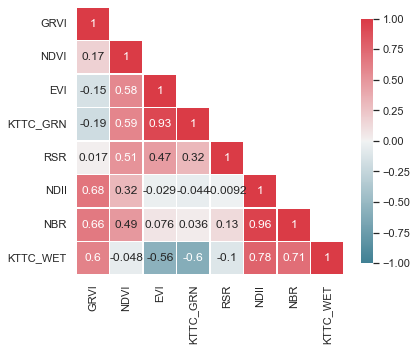

In [7]:
corr_matrix = corr_heatmap(masting_df, vis, 'VI_correlation_matrix_color.png')

,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds
grvi_slope_sds,1.000000,0.172339,-0.146892,-0.194784
ndvi_slope_sds,0.172339,1.000000,0.577111,0.592938
evi_slope_sds,-0.146892,0.577111,1.000000,0.928150
kttc_grn_slope_sds,-0.194784,0.592938,0.928150,1.000000


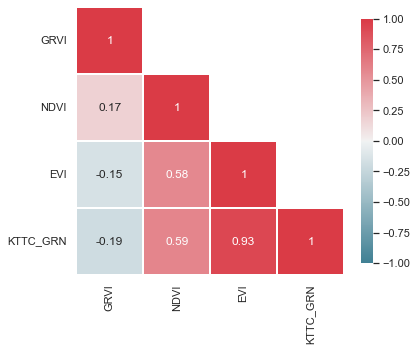

In [8]:
corr_heatmap(masting_df, photosyn_vis)

In [9]:
# null model
lf = 'mast_year ~ 1 + (1|year) + (1|site_idx)'
print('null model: ', lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
print()
print('pseudo-R2: %.3f' % lr.prsquared)
nk = 3
nobs = len(masting_df)
aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
null_aicc = aic_corr
print('AICc = %.3f' % aic_corr)
pred_table = lr.pred_table()
print('ncorrect = %d' % pred_table[1, 1])
print('nmissed = %d' % pred_table[1, 0])
print('nfalse = %d' % pred_table[0, 1])
accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
print('Accuracy = %.3f' % accuracy)
k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
print('kappa = %.3f' % k)

null model:  mast_year ~ 1 + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.432105
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                 0.01128
Time:                        13:55:36   Log-Likelihood:                -43.643
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                    0.6078
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -68.9130     70.100     -0.983      

In [10]:
nvis = len(photosyn_vis)
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
prsq = list()
aicc = list()
acc = list()
kappa = list()
ncorrect = list()
nmissed = list()
nfalse = list()
for vi in photosyn_vis:
    lf = 'mast_year ~ %s_slope_sds + (1|year) + (1|site_idx)' % vi.lower()
    print(lf)
    lm = smf.logit(lf, masting_df)
    lr = lm.fit(maxiter=1000)
    print(lr.summary())
    print()
    print(lr.pred_table())
    print()
    coeff_vals.append(lr.params[1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])
    prsq.append(lr.prsquared)
    nk = 4
    nobs = len(masting_df)
    aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
    aicc.append(aic_corr)
    pred_table = lr.pred_table()
    ncorrect.append(pred_table[1, 1])
    nmissed.append(pred_table[1, 0])
    nfalse.append(pred_table[0, 1])
    accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
    acc.append(accuracy)
    k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
    kappa.append(k)
daicc = list()
weight = list()
for val in aicc:
    diff = val - np.min(aicc)
    daicc.append(diff)
    weight.append(np.exp(-0.5 * diff))
weight /= np.sum(weight)
null_daicc = null_aicc - np.min(aicc)
print('null dAICc = %.3f' % null_daicc)

mast_year ~ grvi_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.425542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                 0.02630
Time:                        13:55:36   Log-Likelihood:                -42.980
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                    0.5084
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -79.8878     70.506     -1.133

In [11]:
df = pd.DataFrame({'VI' : photosyn_vis, 'coeff' : coeff_vals, 'CI_low' : CI_low_vals,
                   'CI_high' : CI_high_vals, 'pseudo-R2' : prsq, 'AICc' : aicc,
                   'dAICc' : daicc, 'weight' : weight, 'n_correct' : ncorrect,
                   'n_missed' : nmissed, 'n_false' : nfalse, 'Accuracy' : acc,
                   'kappa' : kappa})
df.sort_values(by=['AICc', 'kappa'], ascending=[True, False])

,VI,coeff,CI_low,CI_high,pseudo-R2,AICc,dAICc,weight,n_correct,n_missed,n_false,Accuracy,kappa
3,KTTC_GRN,0.382302,-0.288561,1.053164,0.026983,94.148746,0.000000,0.320274,0.0,16.0,0.0,0.841584,0.0
0,GRVI,-0.313405,-0.844662,0.217853,0.026295,94.209413,0.060667,0.310705,0.0,16.0,0.0,0.841584,0.0
2,EVI,0.234331,-0.470890,0.939552,0.016942,95.035105,0.886359,0.205613,0.0,16.0,0.0,0.841584,0.0
1,NDVI,0.057469,-0.510996,0.625935,0.011737,95.494602,1.345856,0.163408,0.0,16.0,0.0,0.841584,0.0


In [12]:
def plot_coefficients(labels, coeff_vals, CI_low_vals, CI_high_vals, color, outfname):
    nlabels = len(labels)
    y = np.linspace(0, 1, nlabels+1)
    y_loc = [(yy + y[i+1]) / 2 for i, yy in enumerate(y[:-1])]
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6.5, (0.438333 * nlabels - 0.006667))
    plt.plot([CI_low_vals, CI_high_vals], [y_loc, y_loc], '-|', color=color)
    plt.plot([0, 0], [0, 1], '--k')
    plt.xlabel('Logistic regression coefficients', fontsize=12)
    plt.ylim([0, 1])
    ax1.set_ylabel('Landsat VI', fontsize=12)
    ax1.set_yticks(y_loc)
    ax1.set_yticklabels(labels, fontsize=12)
    plt.plot(coeff_vals, y_loc, 'D', color=color)
    if outfname:
        plt.savefig(outfname, dpi=300, bbox_inches='tight')
    plt.show()

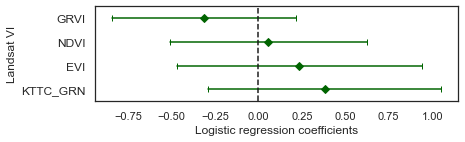

In [13]:
plot_coefficients(photosyn_vis[::-1], coeff_vals[::-1], CI_low_vals[::-1], CI_high_vals[::-1],
                  'darkgreen', 'photosyn_VIs_logistic_coeffs_color.png')

,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,rsr_slope_sds
ndii_slope_sds,1.000000,0.959594,0.778377,-0.009242
nbr_slope_sds,0.959594,1.000000,0.714955,0.128925
kttc_wet_slope_sds,0.778377,0.714955,1.000000,-0.104443
rsr_slope_sds,-0.009242,0.128925,-0.104443,1.000000


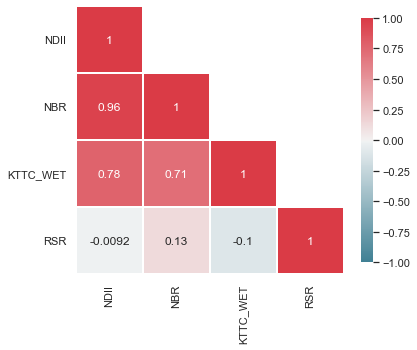

In [14]:
corr_heatmap(masting_df, moisture_vis)

In [15]:
nvis = len(moisture_vis)
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
prsq = list()
aicc = list()
acc = list()
kappa = list()
ncorrect = list()
nmissed = list()
nfalse = list()
for vi in moisture_vis:
    lf = 'mast_year ~ %s_slope_sds + (1|year) + (1|site_idx)' % vi.lower()
    print(lf)
    lm = smf.logit(lf, masting_df)
    lr = lm.fit(maxiter=1000)
    print(lr.summary())
    print()
    print(lr.pred_table())
    print()
    coeff_vals.append(lr.params[1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])
    prsq.append(lr.prsquared)
    nk = 4
    nobs = len(masting_df)
    aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
    aicc.append(aic_corr)
    pred_table = lr.pred_table()
    ncorrect.append(pred_table[1, 1])
    nmissed.append(pred_table[1, 0])
    nfalse.append(pred_table[0, 1])
    accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
    acc.append(accuracy)
    k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
    kappa.append(k)
daicc = list()
weight = list()
for val in aicc:
    diff = val - np.min(aicc)
    daicc.append(diff)
    weight.append(np.exp(-0.5 * diff))
weight /= np.sum(weight)
null_daicc = null_aicc - np.min(aicc)
print('null dAICc = %.3f' % null_daicc)

mast_year ~ ndii_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.378605
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                  0.1337
Time:                        13:55:37   Log-Likelihood:                -38.239
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                  0.008091
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -135.3826     80.001     -1.692

In [16]:
df = pd.DataFrame({'VI' : moisture_vis, 'coeff' : coeff_vals, 'CI_low' : CI_low_vals,
                   'CI_high' : CI_high_vals, 'pseudo-R2' : prsq, 'AICc' : aicc,
                   'dAICc' : daicc, 'weight' : weight, 'n_correct' : ncorrect,
                   'n_missed' : nmissed, 'n_false' : nfalse, 'Accuracy' : acc,
                   'kappa' : kappa})
df.sort_values(by=['AICc', 'kappa'], ascending=[True, False])

,VI,coeff,CI_low,CI_high,pseudo-R2,AICc,dAICc,weight,n_correct,n_missed,n_false,Accuracy,kappa
0,NDII,-0.861486,-1.439793,-0.283180,0.133693,84.728291,0.000000,0.445147,3.0,13.0,1.0,0.861386,0.252643
1,NBR,-0.813617,-1.350271,-0.276963,0.126933,85.325031,0.596740,0.330311,3.0,13.0,1.0,0.861386,0.252643
2,KTTC_WET,-0.781418,-1.316166,-0.246670,0.116437,86.251633,1.523342,0.207833,3.0,13.0,1.0,0.861386,0.252643
3,RSR,1.580122,-0.267308,3.427552,0.059329,91.293213,6.564922,0.016709,0.0,16.0,0.0,0.841584,0.000000


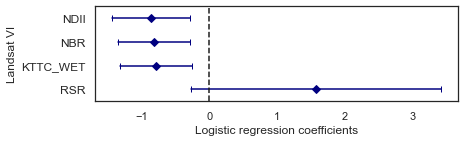

In [17]:
plot_coefficients(moisture_vis[::-1], coeff_vals[::-1], CI_low_vals[::-1], CI_high_vals[::-1],
                  'navy', 'moisture_VI_logistic_coeffs_color.png')

In [18]:
model_vis = ['NDII']
lf = 'mast_year ~ ndii_slope_sds + (1|year) + (1|site_idx)'
print(lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
print()
masting_df['predicted'] = np.round(lr.predict()).astype(int)

mast_year ~ ndii_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.378605
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                  0.1337
Time:                        13:55:37   Log-Likelihood:                -38.239
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                  0.008091
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -135.3826     80.001     -1.692

In [19]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,-4.026749,-4.324296,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,-2.948561,-2.580741,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,-4.882442,-4.570027,1


In [20]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,0.587061,-0.016639,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,1.855367,1.223758,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,0.507711,0.210233,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,0.687727,-0.008747,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,-0.640236,-0.399085,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,0.301699,-0.177672,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,-1.797680,-0.322701,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,-0.513683,0.419053,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,-0.716800,0.000884,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,0.620611,0.095349,0


In [21]:
false_masting = masting_df[masting_df['predicted'] - masting_df['mast_year'] == 1]
false_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
48,KLOO,2012,0,1,-3.79206,-1.654578,1.072333,2.910269,-5.578739,-1.514118,-1.86708,-2.994625,1


In [22]:
models = ['1']
for vi1 in photosyn_vis:
    vi1_name = '%s_slope_sds' % vi1.lower()
    for vi2 in moisture_vis:
        vi2_name = '%s_slope_sds' % vi2.lower()
        corr = corr_matrix[vi1_name][vi2_name]
        if abs(corr) < np.sqrt(0.5):
            models.append('%s + %s' % (vi1_name, vi2_name))
print(models)
print()
#
prsq = list()
aicc = list()
acc = list()
kappa = list()
ncorrect = list()
nmissed = list()
nfalse = list()
for model in models:
    lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % model
    print(lf)
    lm = smf.logit(lf, masting_df)
    lr = lm.fit(maxiter=1000)
    print(lr.summary())
    print()
    print(lr.pred_table())
    print()
    prsq.append(lr.prsquared)
    nk = 5
    nobs = len(masting_df)
    aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
    aicc.append(aic_corr)
    pred_table = lr.pred_table()
    ncorrect.append(lr.pred_table()[1, 1])
    nmissed.append(lr.pred_table()[1, 0])
    nfalse.append(lr.pred_table()[0, 1])
    accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
    acc.append(accuracy)
    k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
    kappa.append(k)
daicc = list()
weight = list()
for val in aicc:
    diff = val - np.min(aicc)
    daicc.append(diff)
    weight.append(np.exp(-0.5 * diff))
weight /= np.sum(weight)
null_daicc = null_aicc - np.min(aicc)
print('null dAICc = %.3f' % null_daicc)

['1', 'grvi_slope_sds + ndii_slope_sds', 'grvi_slope_sds + nbr_slope_sds', 'grvi_slope_sds + kttc_wet_slope_sds', 'grvi_slope_sds + rsr_slope_sds', 'ndvi_slope_sds + ndii_slope_sds', 'ndvi_slope_sds + nbr_slope_sds', 'ndvi_slope_sds + kttc_wet_slope_sds', 'ndvi_slope_sds + rsr_slope_sds', 'evi_slope_sds + ndii_slope_sds', 'evi_slope_sds + nbr_slope_sds', 'evi_slope_sds + kttc_wet_slope_sds', 'evi_slope_sds + rsr_slope_sds', 'kttc_grn_slope_sds + ndii_slope_sds', 'kttc_grn_slope_sds + nbr_slope_sds', 'kttc_grn_slope_sds + kttc_wet_slope_sds', 'kttc_grn_slope_sds + rsr_slope_sds']

mast_year ~ 1 + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.432105
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       98
Method:                           

                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            4
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                  0.1734
Time:                        13:55:38   Log-Likelihood:                -36.485
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                  0.004099
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -189.2440     88.450     -2.140      0.032    -362.603     -15.885
ndvi_slope_sds     0.9392      0.559      1.679      0.093      -0.157       2.036
ndii_slope_sds    -1.3309      0.485


[[84.  1.]
 [13.  3.]]

mast_year ~ evi_slope_sds + rsr_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.411038
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            4
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                 0.05948
Time:                        13:55:38   Log-Likelihood:                -41.515
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                    0.2625
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept

In [23]:
df = pd.DataFrame({'model' : models, 'pseudo-R2' : prsq, 'AICc' : aicc,
                   'dAICc' : daicc, 'weight' : weight, 'n_correct' : ncorrect,
                   'n_missed' : nmissed, 'n_false' : nfalse, 'Accuracy' : acc,
                   'kappa' : kappa})
df.sort_values(by=['AICc', 'kappa'], ascending=[True, False])

,model,pseudo-R2,AICc,dAICc,weight,n_correct,n_missed,n_false,Accuracy,kappa
6,ndvi_slope_sds + nbr_slope_sds,0.188117,82.094749,0.000000,0.377621,4.0,12.0,0.0,0.881188,0.359408
5,ndvi_slope_sds + ndii_slope_sds,0.173427,83.391533,1.296784,0.197453,2.0,14.0,1.0,0.851485,0.168952
1,grvi_slope_sds + ndii_slope_sds,0.160982,84.490224,2.395475,0.113995,3.0,13.0,1.0,0.861386,0.252643
2,grvi_slope_sds + nbr_slope_sds,0.143165,86.063147,3.968398,0.051919,3.0,13.0,1.0,0.861386,0.252643
13,kttc_grn_slope_sds + ndii_slope_sds,0.139800,86.360206,4.265457,0.044753,3.0,13.0,1.0,0.861386,0.252643
9,evi_slope_sds + ndii_slope_sds,0.135764,86.716495,4.621746,0.037450,3.0,13.0,1.0,0.861386,0.252643
14,kttc_grn_slope_sds + nbr_slope_sds,0.133123,86.949662,4.854913,0.033329,3.0,13.0,1.0,0.861386,0.252643
10,evi_slope_sds + nbr_slope_sds,0.130401,87.189977,5.095228,0.029556,3.0,13.0,1.0,0.861386,0.252643
3,grvi_slope_sds + kttc_wet_slope_sds,0.128255,87.379389,5.284640,0.026885,3.0,13.0,2.0,0.851485,0.227435
11,evi_slope_sds + kttc_wet_slope_sds,0.127995,87.402329,5.307580,0.026578,3.0,13.0,1.0,0.861386,0.252643


In [24]:
model_vis = ['NDVI', 'NBR']
lf = 'mast_year ~ ndvi_slope_sds + nbr_slope_sds + (1|year) + (1|site_idx)'
print(lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
print()
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
for i, vi in enumerate(model_vis):
    coeff_vals.append(lr.params[i+1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])
masting_df['predicted'] = np.round(lr.predict()).astype(int)

mast_year ~ ndvi_slope_sds + nbr_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.354820
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            4
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                  0.1881
Time:                        13:55:38   Log-Likelihood:                -35.837
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                  0.002304
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -165.8325     8

In [25]:
def plot_coefficients(labels, coeff_vals, CI_low_vals, CI_high_vals, outfname):
    nlabels = len(labels)
    y = np.linspace(0, 1, nlabels+1)
    y_loc = [(yy + y[i+1]) / 2 for i, yy in enumerate(y[:-1])]
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6.5, (0.438333 * nlabels - 0.006667))
    plt.plot([CI_low_vals[0], CI_high_vals[0]], [y_loc[0], y_loc[0]], '-|', color='navy')
    plt.plot([CI_low_vals[1], CI_high_vals[1]], [y_loc[1], y_loc[1]], '-|', color='darkgreen')
    plt.plot([0, 0], [0, 1], '--k')
    plt.xlabel('Logistic regression coefficients', fontsize=12)
    plt.ylim([0, 1])
    ax1.set_ylabel('Landsat VI', fontsize=12)
    ax1.set_yticks(y_loc)
    ax1.set_yticklabels(labels[::-1], fontsize=12)
    plt.plot(coeff_vals[0], y_loc[0], 'D', color='navy')
    plt.plot(coeff_vals[1], y_loc[1], 'D', color='darkgreen')
    plt.savefig(outfname, dpi=300, bbox_inches='tight')
    plt.show()

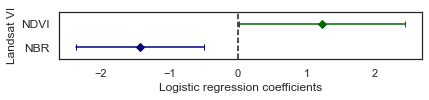

In [26]:
plot_coefficients(model_vis, coeff_vals[::-1], CI_low_vals[::-1], CI_high_vals[::-1],
                  'NDVI+NBR_logistic_coeffs_color.png')

In [27]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,-4.026749,-4.324296,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,-2.948561,-2.580741,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,-4.882442,-4.570027,1
93,SULPHUR,2010,1,3,-0.242225,-0.242163,-0.638210,-0.409288,0.055113,-0.652457,-1.390628,0.034740,1


In [28]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,0.587061,-0.016639,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,1.855367,1.223758,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,0.507711,0.210233,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,0.687727,-0.008747,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,-0.640236,-0.399085,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,0.301699,-0.177672,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,-1.797680,-0.322701,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,-0.513683,0.419053,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,-0.716800,0.000884,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,0.620611,0.095349,0


In [29]:
false_masting = masting_df[masting_df['predicted'] - masting_df['mast_year'] == 1]
false_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted


In [30]:
model_vis = ['NDVI', 'NDII']
lf = 'mast_year ~ ndvi_slope_sds + ndii_slope_sds + (1|year) + (1|site_idx)'
print(lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
print()
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
for i, vi in enumerate(model_vis):
    coeff_vals.append(lr.params[i+1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])
masting_df['predicted'] = np.round(lr.predict()).astype(int)

mast_year ~ ndvi_slope_sds + ndii_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.361240
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            4
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:                  0.1734
Time:                        13:55:39   Log-Likelihood:                -36.485
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                  0.004099
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -189.2440     

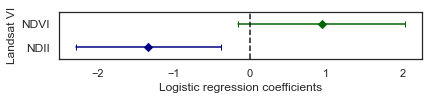

In [31]:
plot_coefficients(model_vis, coeff_vals[::-1], CI_low_vals[::-1], CI_high_vals[::-1],
                  'NDVI+NDII_logistic_coeffs_color.png')

In [32]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,-4.026749,-4.324296,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,-4.882442,-4.570027,1


In [33]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,0.587061,-0.016639,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,1.855367,1.223758,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,0.507711,0.210233,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,0.687727,-0.008747,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,-0.640236,-0.399085,0
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,-2.948561,-2.580741,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,0.301699,-0.177672,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,-1.797680,-0.322701,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,-0.513683,0.419053,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,-0.716800,0.000884,0


In [34]:
false_masting = masting_df[masting_df['predicted'] - masting_df['mast_year'] == 1]
false_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,predicted
2,CHITTY,1993,0,0,-0.483825,-0.065527,-0.615358,-0.581983,0.243178,-2.36215,-1.916494,-1.660138,1


In [35]:
models = ['ndvi_slope_sds + nbr_slope_sds',
          'ndvi_slope_sds + ndii_slope_sds']
nmodels = len(models)
#
prsq = list()
aicc = list()
acc = list()
kappa = list()
ncorrect = list()
nmissed = list()
nfalse = list()
for i, model in enumerate(models):
    lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % model
    lm = smf.logit(lf, masting_df)
    lr = lm.fit(maxiter=1000)
    masting_df['model_%d_predicted' % (i+1)] = lr.predict()
    prsq.append(lr.prsquared)
    nk = 5
    nobs = len(masting_df)
    aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
    aicc.append(aic_corr)
    pred_table = lr.pred_table()
    ncorrect.append(lr.pred_table()[1, 1])
    nmissed.append(lr.pred_table()[1, 0])
    nfalse.append(lr.pred_table()[0, 1])
    accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
    acc.append(accuracy)
    k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
    kappa.append(k)
daicc = list()
weight = list()
for val in aicc:
    diff = val - np.min(aicc)
    daicc.append(diff)
    weight.append(np.exp(-0.5 * diff))
weight /= np.sum(weight)

Optimization terminated successfully.
         Current function value: 0.354820
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361240
         Iterations 8


In [36]:
df = pd.DataFrame({'model' : models, 'pseudo-R2' : prsq, 'AICc' : aicc,
                   'dAICc' : daicc, 'weight' : weight, 'n_correct' : ncorrect,
                   'n_missed' : nmissed, 'n_false' : nfalse, 'Accuracy' : acc,
                   'kappa' : kappa})
df.sort_values(by=['AICc', 'kappa'], ascending=[True, False])

,model,pseudo-R2,AICc,dAICc,weight,n_correct,n_missed,n_false,Accuracy,kappa
0,ndvi_slope_sds + nbr_slope_sds,0.188117,82.094749,0.000000,0.656648,4.0,12.0,0.0,0.881188,0.359408
1,ndvi_slope_sds + ndii_slope_sds,0.173427,83.391533,1.296784,0.343352,2.0,14.0,1.0,0.851485,0.168952


In [37]:
masting_df.drop(columns=['predicted'], inplace=True)
combined_prediction = np.zeros_like(np.array(masting_df['model_1_predicted']))
weight = list(df['weight'])
for i in range(nmodels):
    combined_prediction += weight[i] * np.array(masting_df['model_%d_predicted' % (i+1)])
masting_df['combined_model_predicted'] = np.round(combined_prediction).astype(int)
# for vi in vis:
#     masting_df.drop(columns=['%s_slope_sds' % vi.lower()], inplace=True)
masting_df

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,model_1_predicted,model_2_predicted,combined_model_predicted
0,CHITTY,1991,0,0,-0.829970,0.395818,0.562327,0.291268,0.928034,-0.246019,-0.102297,-0.487206,0.079908,0.077991,0
1,CHITTY,1992,0,0,0.314277,-0.283064,0.159866,0.099029,0.131635,0.647337,0.561732,0.516141,0.016888,0.016150,0
2,CHITTY,1993,0,0,-0.483825,-0.065527,-0.615358,-0.581983,0.243178,-2.362150,-1.916494,-1.660138,0.436817,0.525030,0
3,CHITTY,1994,0,0,0.986045,0.449790,0.667906,0.496778,-0.111049,0.308962,0.554189,-0.135059,0.047948,0.058204,0
4,CHITTY,1996,0,0,0.994249,0.592172,0.425852,0.375119,-0.019742,0.866513,0.935755,0.556554,0.039345,0.038973,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,SULPHUR,2013,0,3,0.271716,0.894232,-0.014425,0.115988,-0.264852,0.553423,0.365757,0.185171,0.298807,0.222877,0
97,SULPHUR,2014,1,3,0.446133,0.172943,0.013885,-0.063112,0.102800,0.362702,0.376059,0.047183,0.169219,0.184591,0
98,SULPHUR,2015,0,3,0.323242,0.813421,0.329445,0.400376,0.406497,0.565979,0.579099,0.062169,0.250912,0.239659,0
99,SULPHUR,2016,0,3,-0.103053,0.392447,0.071401,0.060286,0.044753,0.160579,0.067463,-0.022664,0.328155,0.305056,0


In [38]:
pred_table = np.zeros((2,2)).astype(int)
pred_table[0, 0] = len(masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 0])
pred_table[0, 1] = len(masting_df[masting_df['combined_model_predicted'] - masting_df['mast_year'] == 1])
pred_table[1, 0] = len(masting_df[masting_df['mast_year'] - masting_df['combined_model_predicted'] == 1])
pred_table[1, 1] = len(masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 2])
print(pred_table)
accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
print('Overall accuracy: %.3f' % accuracy)
k = cohen_kappa_score(masting_df['mast_year'], masting_df['combined_model_predicted'])
print('Cohen\'s kappa: %.3f' % k)

[[85  0]
 [13  3]]
Overall accuracy: 0.871
Cohen's kappa: 0.280


In [39]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,model_1_predicted,model_2_predicted,combined_model_predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,-4.026749,-4.324296,0.853731,0.895488,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,-2.948561,-2.580741,0.771207,0.402076,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,-4.882442,-4.570027,0.984227,0.987264,1


In [40]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['combined_model_predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,model_1_predicted,model_2_predicted,combined_model_predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,0.587061,-0.016639,0.176172,0.162186,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,1.855367,1.223758,0.079211,0.067996,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,0.507711,0.210233,0.131298,0.167993,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,0.687727,-0.008747,0.100829,0.089899,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,-0.640236,-0.399085,0.319258,0.299678,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,0.301699,-0.177672,0.154228,0.245202,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,-1.797680,-0.322701,0.240381,0.235302,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,-0.513683,0.419053,0.102594,0.132555,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,-0.716800,0.000884,0.268222,0.345045,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,0.620611,0.095349,0.136470,0.130137,0


In [41]:
false_masting = masting_df[masting_df['combined_model_predicted'] - masting_df['mast_year'] == 1]
false_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds,model_1_predicted,model_2_predicted,combined_model_predicted
